## Import modules: 

In [121]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
import seaborn as sns

import bokeh.io
import bokeh.plotting
import holoviews as hv 
import hvplot
import hvplot.pandas

import re

## Function definitions: 

In [102]:
def essential_subset(df, subset_cols, subset_name):
    df_temp = df[['Rv_ID', 'gene_name']+subset_cols].copy()
    df_temp[subset_name] = df_temp.sum(numeric_only=True, axis = 1)
    
    df_temp.sort_values(by=subset_name, ascending=False, inplace=True)
    df_temp.reset_index(inplace=True, drop=True)
    df_temp = df_temp[['Rv_ID', 'gene_name', subset_name] + subset_cols]
    
    return df_temp

## Files and paths: 

In [103]:
dir_data = '../../data/standardized_data/'
dir_figs = '../../figures/Tn_mat_stats/'

Load binary dataset: 

In [104]:
# version = 'old'
version = 'clare_basis'
# version = 'clare_all'


In [105]:
if version == 'old':
    bin_file = os.path.join(dir_data, 'result_bin_matrix_2020_08_27.csv') ## data set without Claire's screens
elif version == 'clare_all':
    bin_file = os.path.join(dir_data, 'result_bin_matrix_2021_08_27.csv') ## data set with all of Claire's pairwise combinations
elif version == 'clare_basis':
    bin_file = os.path.join(dir_data, 'result_bin_matrix_2021_08_27_BASIS.csv') ## data set only Claire's mutant vs. wildtype screens
    lfc_file = os.path.join(dir_data, 'result_logfc_matrix_2021_08_27_BASIS.csv')
    
df_bin = pd.read_csv(bin_file)
df_lfc = pd.read_csv(lfc_file)
df_bin.head(2)

,Rv_ID,PE35_KO_vs_mbio_H37Rv,PPE68_KO_vs_mbio_H37Rv,Rv0950c_KO_vs_CB_WT,Rv0954_KO_vs_RJ_WT,Rv1096_KO_vs_CB_WT,Rv3005c_KO_day32_vs_dejesus_H37Rv_day32,Rv3594_KO_vs_Rubin_FLUTE_WT,Rv3684_KO_vs_CB_WT,Rv3717_KO_vs_Rubin_FLUTE_WT,...,Cast.EiJ_vs_C57BL.6J,IFNG_vs_C57BL.6J,NOD.ShiLtJ_vs_C57BL.6J,NOS_vs_C57BL.6J,NZO.H1LtJ_vs_C57BL.6J,PWK.PhJ_vs_C57BL.6J,Phox_vs_C57BL.6J,Rag_vs_C57BL.6J,Wsb.Eij_vs_C57BL.6J,in_vitro_vs_C57BL.6J
0,Rv0001,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,Rv0002,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [106]:
cols_temp_CS = [col for col in df_lfc.columns if 'C57BL.6J' in col]
len(cols_temp_CS)

61

In [107]:
fn_col_desc = '../../data/column_descriptors_standardized_092321.xlsx'
df_col_desc = pd.read_excel(fn_col_desc)
df_col_desc.head(1)

,column_ID,wig_files,control,experimental,column_ID_2,column_ID_SI,num_replicates_control,num_replicates_experimental,meaning,year,...,carbon_source,stress_description,GI_RvID,GI_name,MicArr_or_TnSeq,stat_analysis,mouse_strain,cell_type,Mtb_strain,plot_SI_graph
0,2003A_Sassetti,NaN,NaN,NaN,NaN,2003A_Sassetti,NaN,NaN,NaN,2003.0,...,glycerol,-,NaN,NaN,microarray,NaN,NaN,NaN,H37Rv,No


In [108]:
df_col_desc.in_vitro_cell_vivo.value_counts()

in_vivo             86
in_vitro            47
in_cell              2
in_vivo_in_vitro     2
Name: in_vitro_cell_vivo, dtype: int64

In [109]:
df_bin['sum_CES'] = df_bin.sum(numeric_only=True, axis = 1)

### Annotations: 

In [110]:
#### COG
file_cog = '../../data/annotations/H37Rv_COG_mapping.xlsx'
df_cog_map = pd.read_excel(file_cog)

file_cog_def = '../../data/annotations/cog_names.csv'
df_cog_def = pd.read_csv(file_cog_def)
df_cog_def.rename(columns = {'COG_Desc':'cog_annot'}, inplace = True)

#merge mapping with definitions: 
df_cog_map_def = df_cog_map.merge(df_cog_def, how='left', on = 'COG')
# Merge with binary matrix:
df_bin_cog = df_bin.merge(df_cog_map, how = 'left', on = 'Rv_ID')

#### Tuberculist
file_tub = '../../data/annotations/H37Rv_tuberculist_functional_categories.xlsx'
df_tub = pd.read_excel(file_tub)
df_tub.rename(columns = {'category':'func_tuberculist'}, inplace = True)
# merge
df_bin_annot = df_bin_cog.merge(df_tub, how = 'left', on = 'Rv_ID')
df_bin_annot = df_bin_annot[['Rv_ID', 'gene_name', 'func_tuberculist', 'COG'] + list(df_bin.columns[1:])]
df_bin_annot.iloc[:,:4].head(3)

,Rv_ID,gene_name,func_tuberculist,COG
0,Rv0001,dnaA,information pathways,L
1,Rv0002,dnaN,information pathways,L
2,Rv0003,recF,information pathways,L


# Rank columns by the number of essential genes. 

In [111]:
df_bin.sum(numeric_only=True).sort_values(ascending = False).head(20)

sum_CES                                          23736.0
dejesus_Rv1432_day0_vs_dejesus_H37Rv_day0          798.0
dejesus_Rv1565c_day32_vs_dejesus_H37Rv_day32       736.0
zhang_wt_mouse_d45_vs_zhang_input_library          627.0
C57BL.6J_vs_mbio_H37Rv                             608.0
dejesus_Rv1432_day32_vs_dejesus_H37Rv_day32        597.0
dejesus_H37Rv_day32_vs_dejesus_H37Rv_day0          594.0
dejesus_Rv2680_day32_vs_dejesus_H37Rv_day32        579.0
Rv3005c_KO_day32_vs_dejesus_H37Rv_day32            578.0
dejesus_Rv2680_day0_vs_dejesus_H37Rv_day0          552.0
dejesus_Rv1565c_day0_vs_dejesus_H37Rv_day0         552.0
griffin_glycerol_vs_mbio_H37Rv                     503.0
carey_621_vs_carey_rv                              455.0
dejesus_Rv2680_day32_vs_dejesus_Rv2680_day0        426.0
minato_minimal_plate_vs_minato_rich_plate          419.0
nambi_2015_ctpC_vs_nambi_2015_wt                   406.0
marP_KO_vs_marP_WT                                 368.0
zhang_Tyloxapol_pH_6.5_vs_zhang

Visualize: 

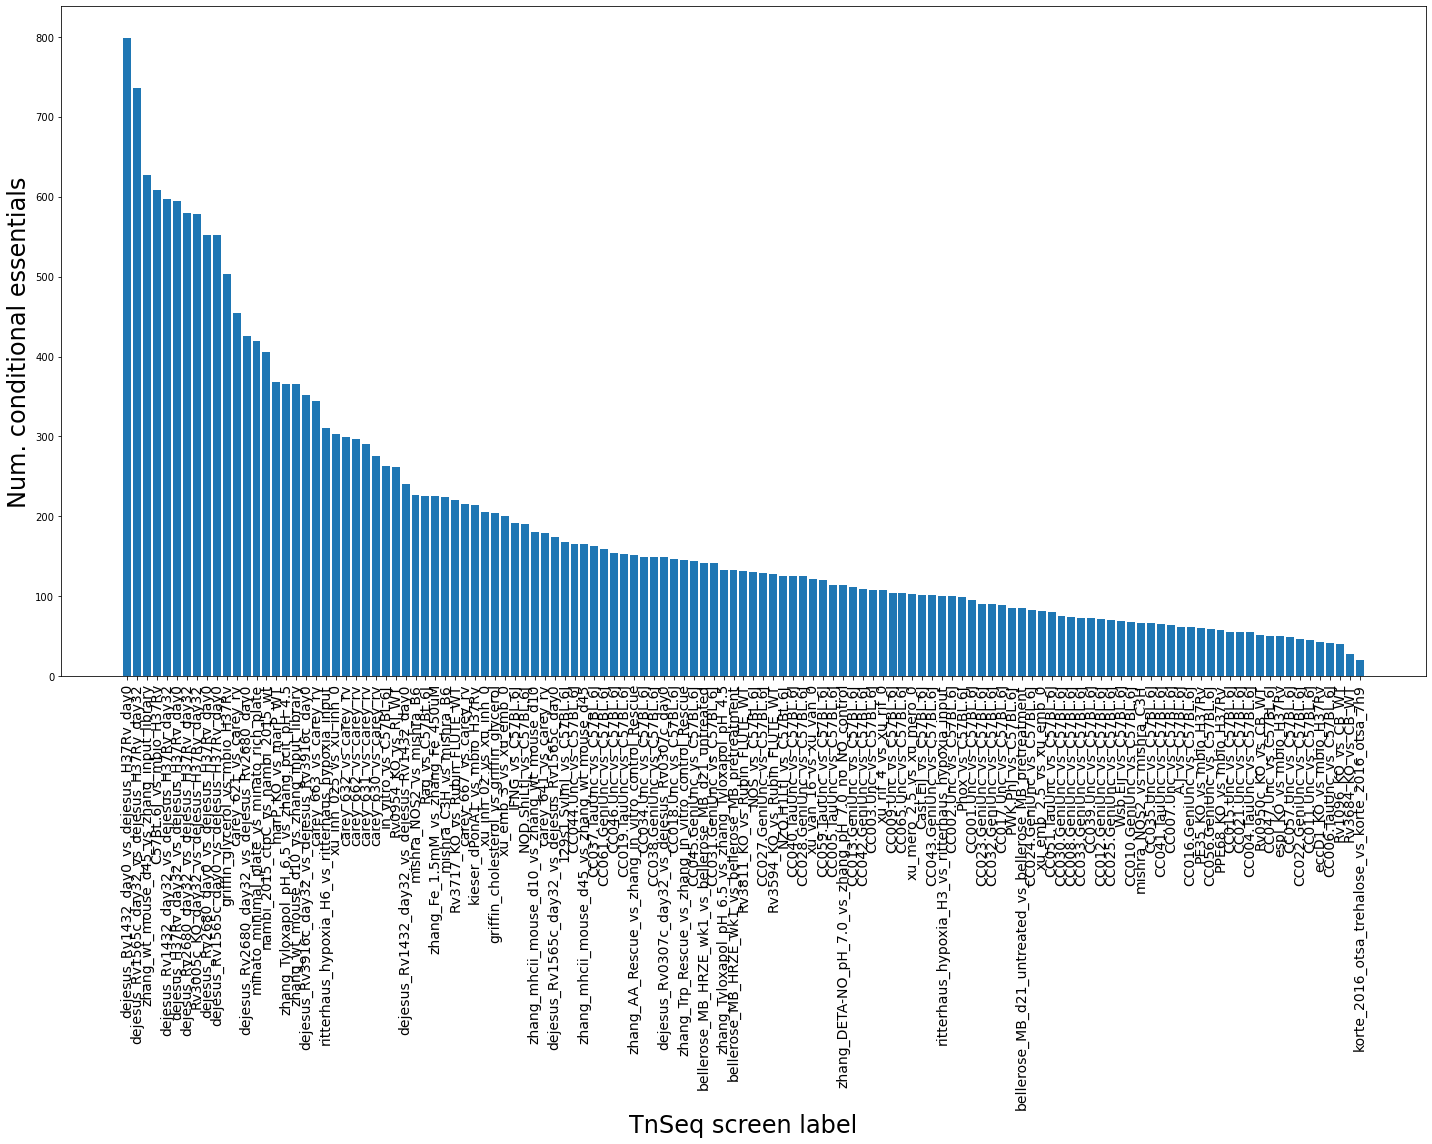

In [112]:
df_Tn_screen_stats = df_bin[df_bin.columns[:-1]].sum(numeric_only=True).sort_values(ascending = False)
vals = df_Tn_screen_stats.values
labels = df_Tn_screen_stats.keys()
xvals = np.arange(len(vals))
plt.figure(figsize = (20,16))
plt.bar(xvals, vals)
plt.ylabel('Num. conditional essentials', fontsize = 24)
xt = plt.xticks(xvals, np.array(labels), rotation = 90, fontsize = 14)
plt.xlabel('TnSeq screen label', fontsize = 24)
plt.tight_layout()
file_out = os.path.join(dir_figs, 'Tn_screen_stats.png')
# plt.savefig(file_out, dpi = 300)


# Rank genes by the number of times they're essential across conditions: 

In [113]:
df_rv_sum = df_bin[['Rv_ID', 'sum_CES']].copy()
df_rv_sum['Rv_num'] = np.arange(df_rv_sum.shape[0])
df_rv_sum.head(5)

,Rv_ID,sum_CES,Rv_num
0,Rv0001,1.0,0
1,Rv0002,0.0,1
2,Rv0003,23.0,2
3,Rv0004,1.0,3
4,Rv0005,2.0,4


In [114]:
df_xticks = df_rv_sum[df_rv_sum.Rv_ID.isin(['Rv0001', 'Rv0500', 'Rv1000c', 'Rv1500', 'Rv2000', 'Rv2500c', 'Rv3000', 'Rv3500c', 'Rv3900c'])]

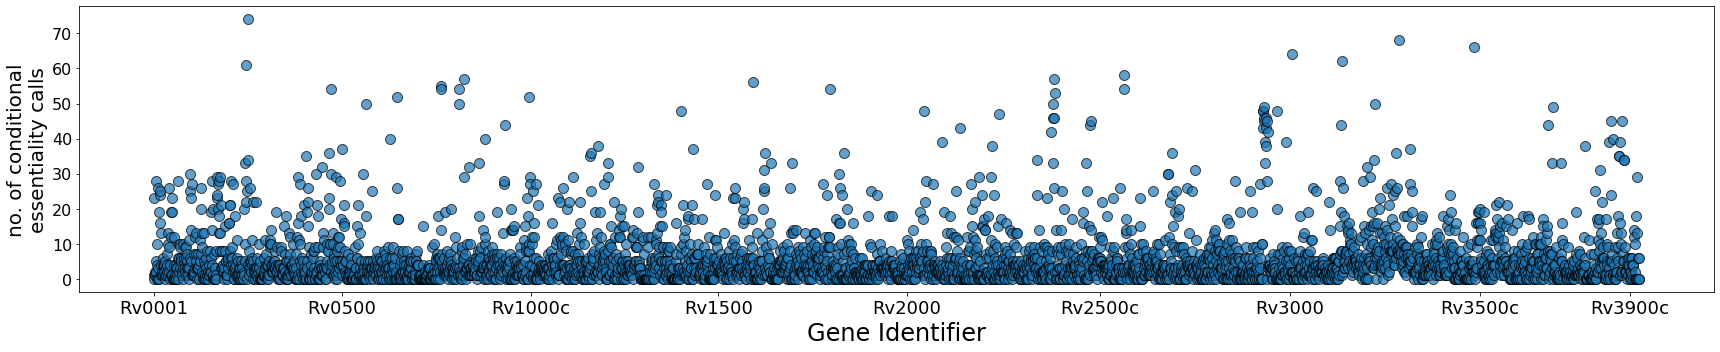

In [115]:
plt.figure(figsize=(24,5))
plt.scatter(df_rv_sum.Rv_num, df_rv_sum.sum_CES, s = 100, edgecolors='k', alpha = 0.7)
# plt.ylim(0, 30)
xt = plt.xticks(list(df_xticks.Rv_num), list(df_xticks.Rv_ID), fontsize = 18)
plt.xlabel('Gene Identifier', fontsize = 24)
yt = plt.yticks(fontsize = 16)
plt.ylabel('no. of conditional\nessentiality calls', fontsize = 20)
plt.tight_layout()



#### sliding window average:

In [116]:
window_size = 4
list_mean_counts = []
for i in range(0, df_rv_sum.shape[0] - window_size):
    window = range(i, i+window_size)
    df_temp = df_rv_sum.iloc[window]
    mean_counts = df_temp.sum_CES.mean()
    list_mean_counts.append(mean_counts)

In [117]:
df_rv_sum_window = df_rv_sum[2:-2].copy()
df_rv_sum_window['mean_sum_CES'] = list_mean_counts

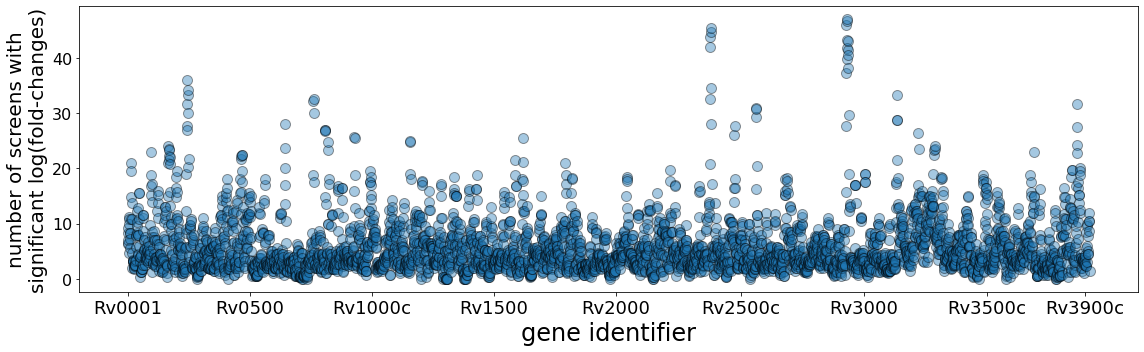

In [118]:
# plt.figure(figsize=(24,8))
plt.figure(figsize = (16,5))

plt.scatter(range(df_rv_sum.shape[0] - window_size), list_mean_counts, s = 100, edgecolors='k', alpha = 0.4)
# plt.plot(range(df_rv_sum.shape[0] - window_size), list_mean_counts, 'k')
# plt.ylim(0, 26)
xt = plt.xticks(list(df_xticks.Rv_num), list(df_xticks.Rv_ID), fontsize = 18)
plt.xlabel('gene identifier', fontsize = 24)
yt = plt.yticks(fontsize = 16)
plt.ylabel('number of screens with\nsignificant log(fold-changes)', fontsize = 20)
plt.tight_layout()

file_out = os.path.join(dir_figs, 'Tn_manhattan_window_092821.png')
plt.savefig(file_out, dpi = 300)

#### Interactive version: 

In [119]:
df_rv_sum_window.hvplot.scatter(
    x = 'Rv_num', 
    y = 'mean_sum_CES', xlabel="Gene Identifier", ylabel="Mean sum CES",
    hover_cols = ['Rv_ID', 'sum_CES'],
    cmap = 'Accent', 
    alpha = 0.4,
    padding = 0.1, 
    size = 55,
    width = 1300,
    height = 500
)

:Scatter   [Rv_num]   (mean_sum_CES,Rv_ID,sum_CES)

## Digging deeper into loci: 

Load the new annotated UniProt dataframe: 

In [136]:
fn_up_func = '../../data/tests/uniprot-proteome_UP000001584.xlsx'
df_up_func = pd.read_excel(fn_up_func)
re_str = 'Rv\d\d\d\dc?'
list_rvids = [re.findall(re_str, str_temp)[0] for str_temp in df_up_func['Gene names']]
df_up_func['Rv_ID'] = list_rvids
df_up_func['annot_int'] = [int(annot.split()[0]) for annot in df_up_func.Annotation]
df_up_func = df_up_func[['Rv_ID', 'annot_int', 'Gene names', 'Function [CC]']].copy()

/home/ajinich/miniconda3/lib/python3.8/site-packages/openpyxl/styles/stylesheet.py:221: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


In [137]:
th = 20
list_rvid_all = df_rv_sum_window[df_rv_sum_window.mean_sum_CES>= th].Rv_ID.tolist()

In [138]:
df_up_func.columns

Index(['Rv_ID', 'annot_int', 'Gene names', 'Function [CC]'], dtype='object')

In [124]:
file_out = '../../data/coessential_loci_th20.xlsx'
df_up_func[df_up_func.Rv_ID.isin(list_rvid_all)].sort_values(by = 'Rv_ID').to_excel(file_out, index = False)

In [125]:
list_rv_id = df_rv_sum_window[df_rv_sum_window.mean_sum_CES>= th].head(7).Rv_ID.tolist()
df_up_func[df_up_func.Rv_ID.isin(list_rv_id)]

,Rv_ID,annot_int,Gene names,Function [CC]
1205,Rv0098,5,fcoT Rv0098 MTCY251.17,FUNCTION: Thiesterase that shows a preference ...
2105,Rv0018c,5,pstP mstp ppp Rv0018c,FUNCTION: Plays an important role in regulatin...
2259,Rv0171,1,mce1C Rv0171,NaN
2271,Rv0173,1,lprK Rv0173,NaN
2528,Rv0172,2,mce1D Rv0172,NaN
2967,Rv0169,4,mce1A Rv0169,NaN
3567,Rv0170,2,mce1B Rv0170,NaN


Now you need to make the different lists: 

In [188]:
def make_loci_boxplots(list_rv_id, df_bin_annot, df_lfc, locus_name):
# Make dictionary of screens with significant hits for each gene in identified loci: 
    rand_x = 0.05

    dict_cols = {}
    for rvid in list_rv_id:
        df_temp = df_bin_annot[df_bin_annot.Rv_ID==rvid]
        cols = df_bin_annot.columns[4:-1]
        cols_sig = [col for col in cols if df_temp[col].values[0] == 1]
        dict_cols[rvid] = cols_sig

    # Get lfc values for those screens, partitioned into mouse CC panel and other screens:     
    ll_lfc_all = []
    ll_lfc_CS = []
    ll_lfc_nonCS = []
    for rvid in list_rv_id:
        cols_temp = dict_cols[rvid]
        cols_temp_CS = [col for col in cols_temp if 'C57BL.6J' in col]
        cols_temp_nonCS = [col for col in cols_temp if not 'C57BL.6J' in col]

        list_lfc = df_lfc[df_lfc.Rv_ID == rvid][cols_temp].values[0]
        list_lfc_CS = df_lfc[df_lfc.Rv_ID == rvid][cols_temp_CS].values[0]
        list_lfc_nonCS = df_lfc[df_lfc.Rv_ID == rvid][cols_temp_nonCS].values[0]

        ll_lfc_all.append(list_lfc)
        ll_lfc_CS.append(list_lfc_CS)
        ll_lfc_nonCS.append(list_lfc_nonCS)

    # make boxplots comparing lfc values: 
    fig = plt.figure(figsize=(24,4))
    ax = fig.add_subplot(131)
    bp = plt.boxplot(ll_lfc_CS, showfliers=False)
    plt.axhspan(-1,1, color = 'gray', alpha = 0.15)
    # add individual points: 
    x_vals = np.arange(1, len(ll_lfc_CS)+1)
    for i in range(len(ll_lfc_CS)):
        ydata = ll_lfc_CS[i]
        xdata = [x_vals[i]]*len(ydata) + np.random.uniform(low=-rand_x, high=+rand_x, size=len(ydata))
        plt.plot(xdata, ydata, 'k.')
    xt = ax.set_xticklabels(list_rv_id, rotation = 45, ha="right", fontdict={'fontsize':10})
    yt = plt.yticks(fontsize = 14)
    yl=plt.ylabel('log2FC for significant\nTnSeq screens', fontsize = 18)
    plt.title(locus_name+'\nsignificant CC panel TnSeq screens', fontsize = 18)

    ax = fig.add_subplot(132)
    bp = plt.boxplot(ll_lfc_nonCS, showfliers=False)
    plt.axhspan(-1,1, color = 'gray', alpha = 0.3)
    x_vals = np.arange(1, len(ll_lfc_nonCS)+1)
    for i in range(len(ll_lfc_nonCS)):
        ydata = ll_lfc_nonCS[i]
        xdata = [x_vals[i]]*len(ydata) + np.random.uniform(low=-rand_x, high=+rand_x, size=len(ydata))
        plt.plot(xdata, ydata, 'k.')
    xt = ax.set_xticklabels(list_rv_id, rotation = 45, ha="right", fontdict={'fontsize':10})
    yt = plt.yticks(fontsize = 14)
    ttl = plt.title(locus_name+'\nother significant TnSeq screens', fontsize = 18)

    ax = fig.add_subplot(133)
    bp = plt.boxplot(ll_lfc_all, showfliers=False)
    plt.axhspan(-1,1, color = 'gray', alpha = 0.3)
    x_vals = np.arange(1, len(ll_lfc_all)+1)
    for i in range(len(ll_lfc_all)):
        ydata = ll_lfc_all[i]
        xdata = [x_vals[i]]*len(ydata) + np.random.uniform(low=-rand_x, high=+rand_x, size=len(ydata))
        plt.plot(xdata, ydata, 'k.')
    xt = ax.set_xticklabels(list_rv_id, rotation = 45, ha="right", fontdict={'fontsize':10})
    yt = plt.yticks(fontsize = 14)
    ttl = plt.title(locus_name+'\nall significant TnSeq screens', fontsize = 18)
    
    ## Saving figures: 
    plt.tight_layout()
    path_fig = '../../figures/Tn_mat_stats/'
    fn = 'boxplot_'+str(locus_name)+'.png'
    plt.savefig(os.path.join(path_fig, fn), dpi = 300)

In [166]:
rvid = 'Rv0644c'
df_temp = df_bin_annot[df_bin_annot.Rv_ID==rvid]
cols = df_bin_annot.columns[4:-1]
cols_temp = [col for col in cols if df_temp[col].values[0] == 1]
cols_temp_CS = [col for col in cols_temp if 'C57BL.6J' in col]
list_lfc = df_lfc[df_lfc.Rv_ID == rvid][cols_temp].values[0]
list_lfc_CS = df_lfc[df_lfc.Rv_ID == rvid][cols_temp_CS].values[0]

In [167]:
df_lfc.head()

,Rv_ID,PE35_KO_vs_mbio_H37Rv,PPE68_KO_vs_mbio_H37Rv,Rv0950c_KO_vs_CB_WT,Rv0954_KO_vs_RJ_WT,Rv1096_KO_vs_CB_WT,Rv3005c_KO_day32_vs_dejesus_H37Rv_day32,Rv3594_KO_vs_Rubin_FLUTE_WT,Rv3684_KO_vs_CB_WT,Rv3717_KO_vs_Rubin_FLUTE_WT,...,Cast.EiJ_vs_C57BL.6J,IFNG_vs_C57BL.6J,NOD.ShiLtJ_vs_C57BL.6J,NOS_vs_C57BL.6J,NZO.H1LtJ_vs_C57BL.6J,PWK.PhJ_vs_C57BL.6J,Phox_vs_C57BL.6J,Rag_vs_C57BL.6J,Wsb.Eij_vs_C57BL.6J,in_vitro_vs_C57BL.6J
0,Rv0001,-0.41,0.01,0.00,0.00,0.00,3.12,-0.06,0.00,-0.06,...,0.00,0.00,0.00,0.00,0.00,0.22,0.00,0.00,0.00,0.00
1,Rv0002,3.28,2.38,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.27,0.00
2,Rv0003,-0.03,-0.08,0.03,-1.20,0.39,3.83,0.31,0.17,-0.62,...,0.03,1.05,1.51,1.15,1.26,0.19,0.61,0.21,1.08,0.63
3,Rv0004,-3.81,-3.39,-2.60,-6.83,1.54,0.00,1.79,1.08,4.91,...,3.07,0.00,5.79,2.35,1.32,0.79,2.16,0.00,4.06,0.00
4,Rv0005,-0.22,0.14,0.13,-0.08,0.27,-2.38,0.70,-0.71,-0.37,...,-0.59,-0.21,-0.41,-1.19,-0.02,-2.43,-0.91,-0.44,0.72,-0.59


In [168]:
file_in = '../../data/coessential_loci_th20.xlsx'
df_loci = pd.read_excel(file_in)
df_loci.columns

Index(['locus', 'locus_name', 'Rv_ID', 'annot_int', 'Gene names',
       'Function [CC]'],
      dtype='object')

In [170]:
locus_name = 'mce-1'
list_rv_id = df_loci[df_loci.locus_name == locus_name].Rv_ID.values

Text(0.5, 1.0, 'mce-1\nsignificant CC panel TnSeq screens')

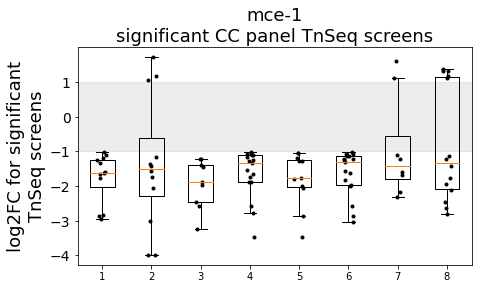

In [183]:
dict_cols = {}
for rvid in list_rv_id:
    df_temp = df_bin_annot[df_bin_annot.Rv_ID==rvid]
    cols = df_bin_annot.columns[4:-1]
    cols_sig = [col for col in cols if df_temp[col].values[0] == 1]
    dict_cols[rvid] = cols_sig

# Get lfc values for those screens, partitioned into mouse CC panel and other screens:     
ll_lfc_all = []
ll_lfc_CS = []
ll_lfc_nonCS = []
for rvid in list_rv_id:
    cols_temp = dict_cols[rvid]
    cols_temp_CS = [col for col in cols_temp if 'C57BL.6J' in col]
    cols_temp_nonCS = [col for col in cols_temp if not 'C57BL.6J' in col]

    list_lfc = df_lfc[df_lfc.Rv_ID == rvid][cols_temp].values[0]
    list_lfc_CS = df_lfc[df_lfc.Rv_ID == rvid][cols_temp_CS].values[0]
    list_lfc_nonCS = df_lfc[df_lfc.Rv_ID == rvid][cols_temp_nonCS].values[0]

    ll_lfc_all.append(list_lfc)
    ll_lfc_CS.append(list_lfc_CS)
    ll_lfc_nonCS.append(list_lfc_nonCS)

# make boxplots comparing lfc values: 
fig = plt.figure(figsize=(24,4))
ax = fig.add_subplot(131)
bp = plt.boxplot(ll_lfc_CS, showfliers=False)
plt.axhspan(-1,1, color = 'gray', alpha = 0.15)
# add individual points: 
x_vals = np.arange(1, len(ll_lfc_CS)+1)
for i in range(len(ll_lfc_CS)):
    ydata = ll_lfc_CS[i]
    xdata = [x_vals[i]]*len(ydata) + np.random.uniform(low=-.1, high=+.1, size=len(ydata))
    plt.plot(xdata, ydata, 'k.')

# xt = ax.set_xticklabels(list_rv_id, rotation = 45, ha="right", fontdict={'fontsize':10})
yt = plt.yticks(fontsize = 14)
yl=plt.ylabel('log2FC for significant\nTnSeq screens', fontsize = 18)
plt.title(locus_name+'\nsignificant CC panel TnSeq screens', fontsize = 18)

/tmp/ipykernel_735234/1386694047.py:30: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(figsize=(24,4))


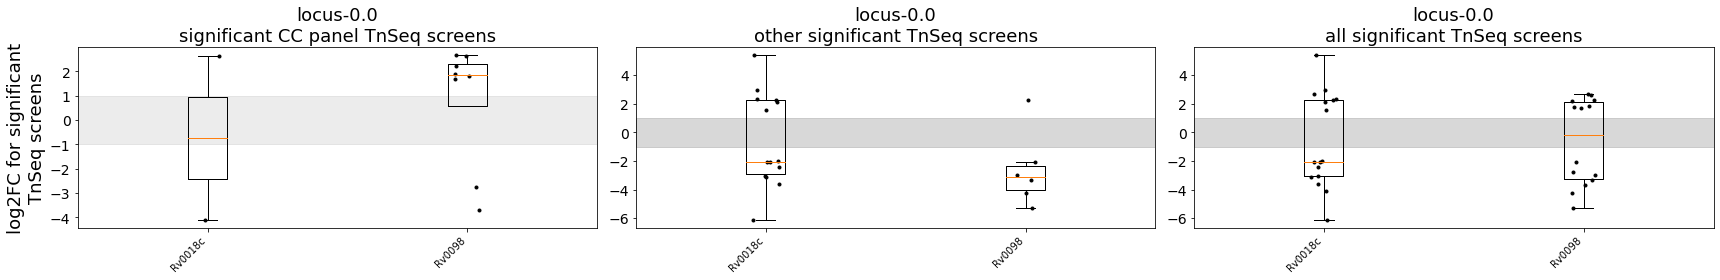

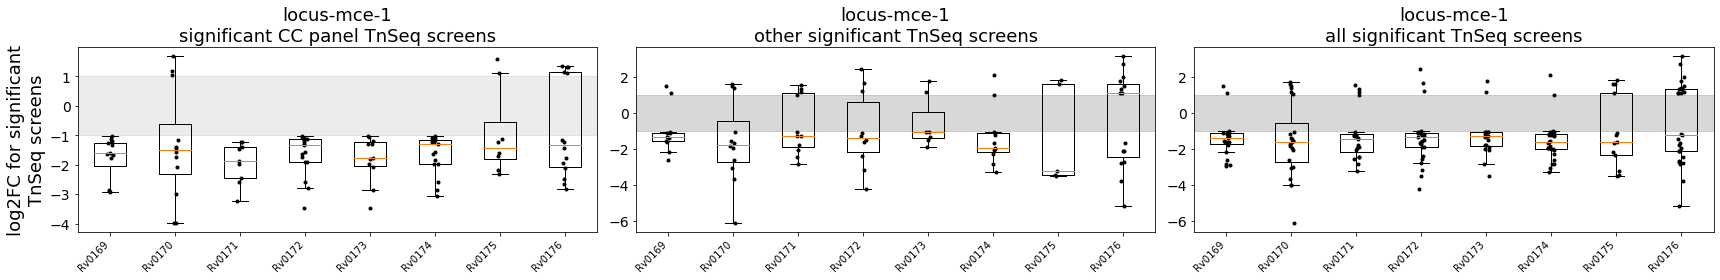

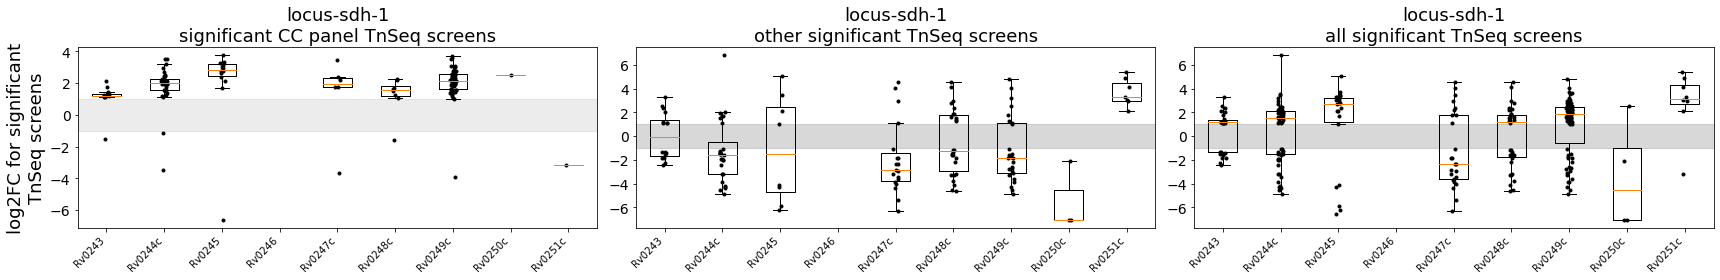

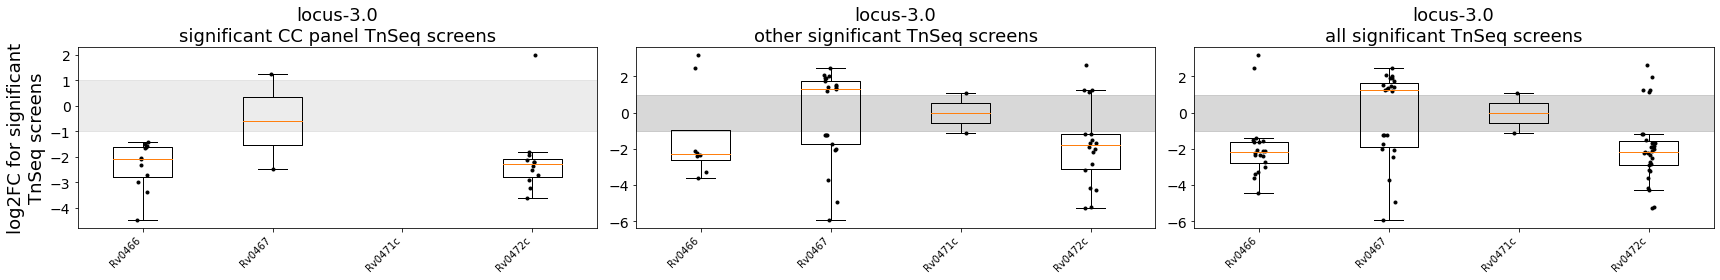

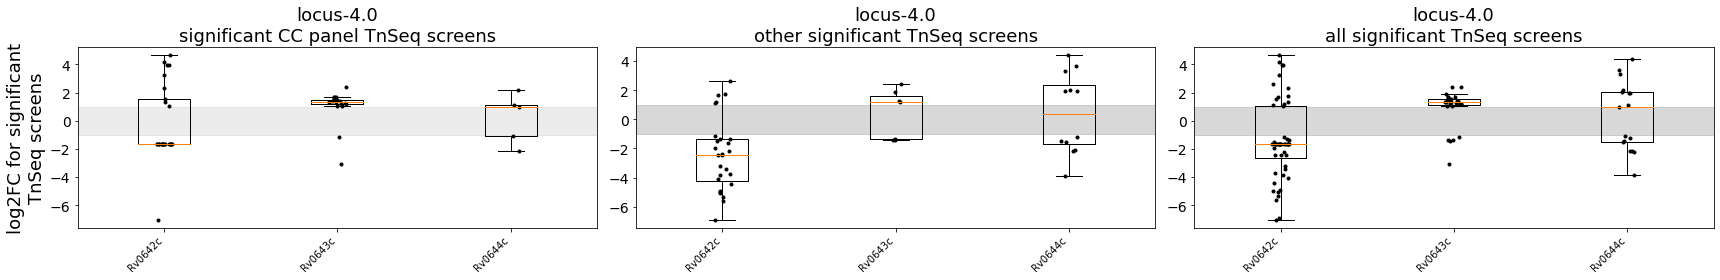

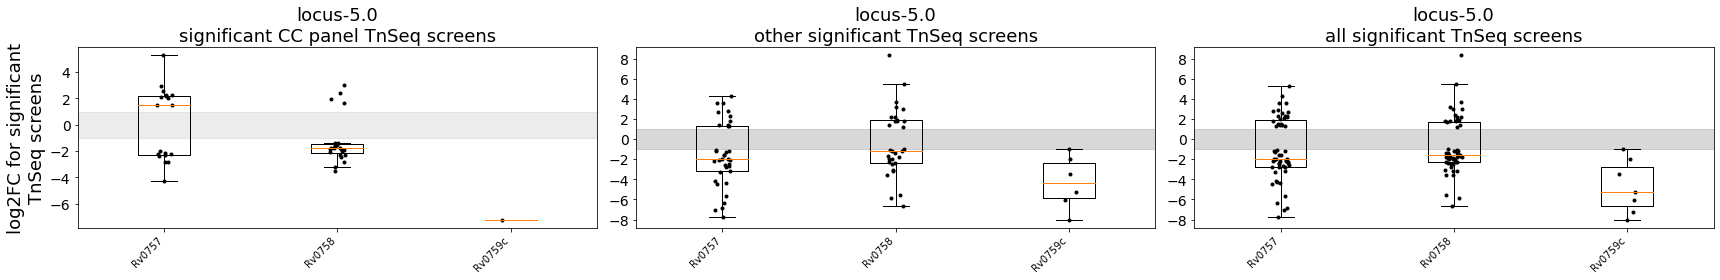

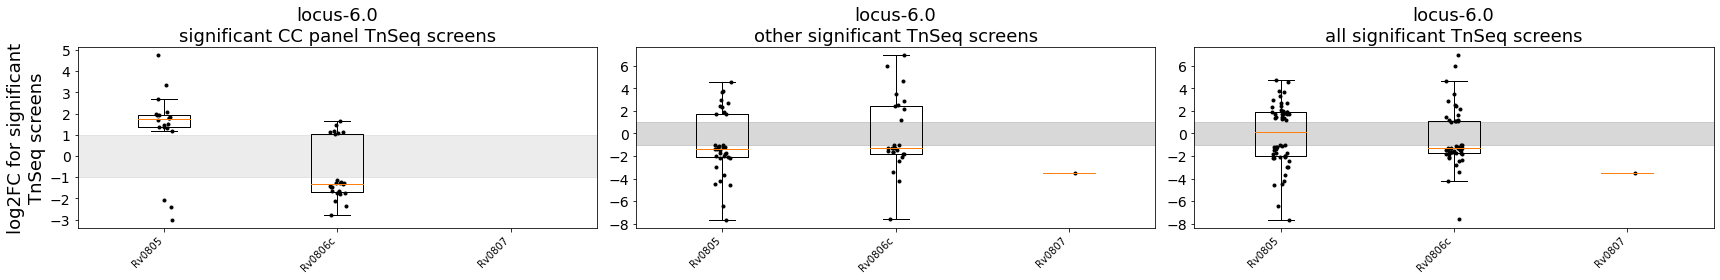

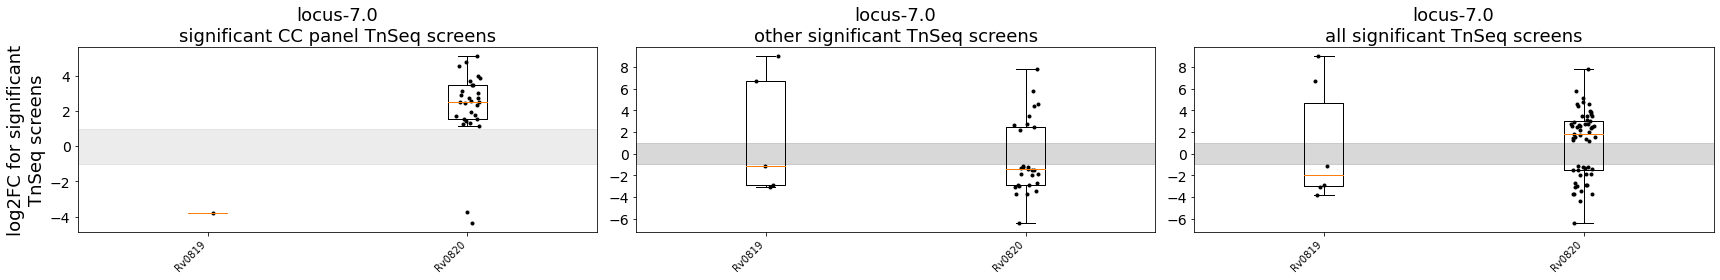

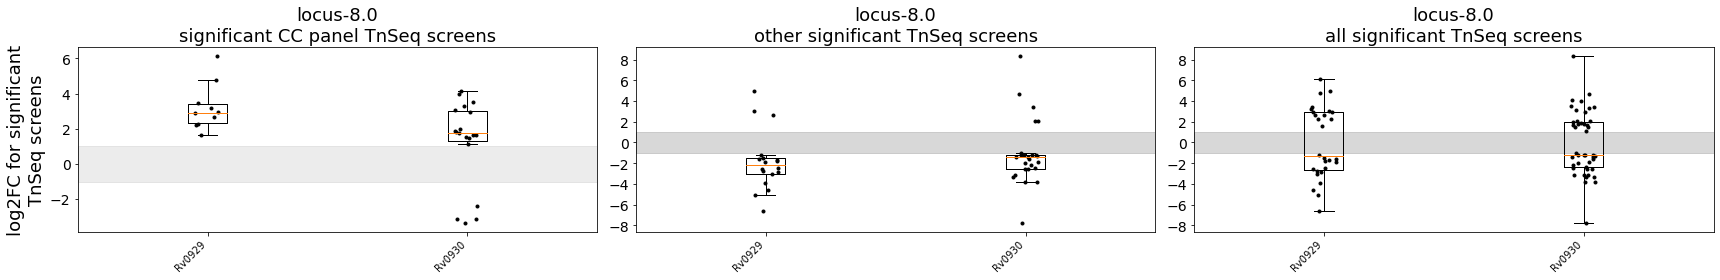

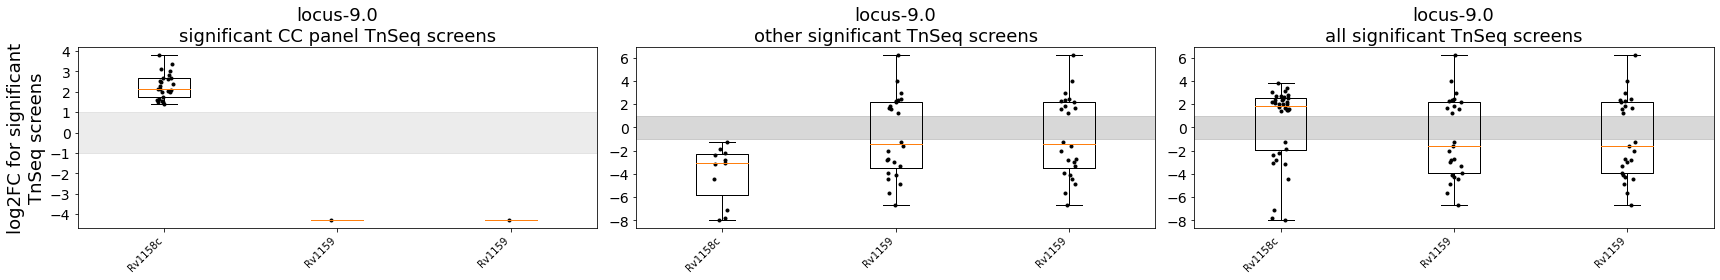

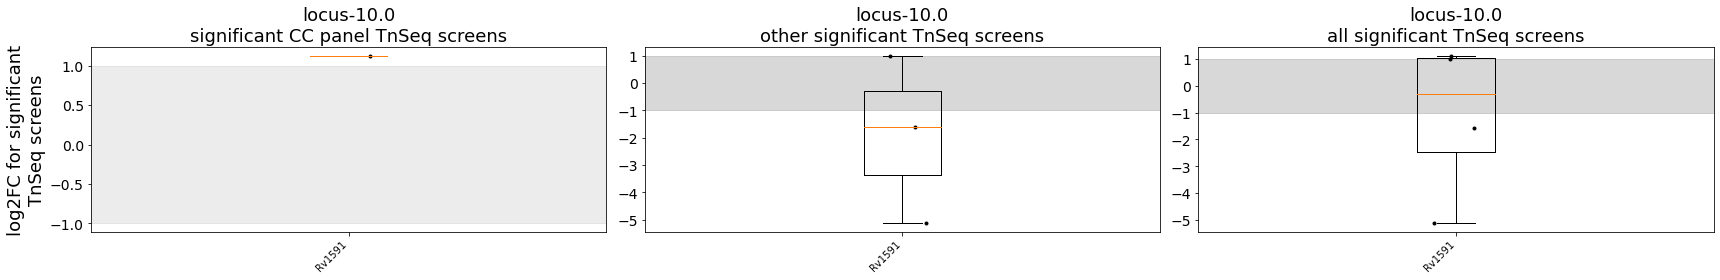

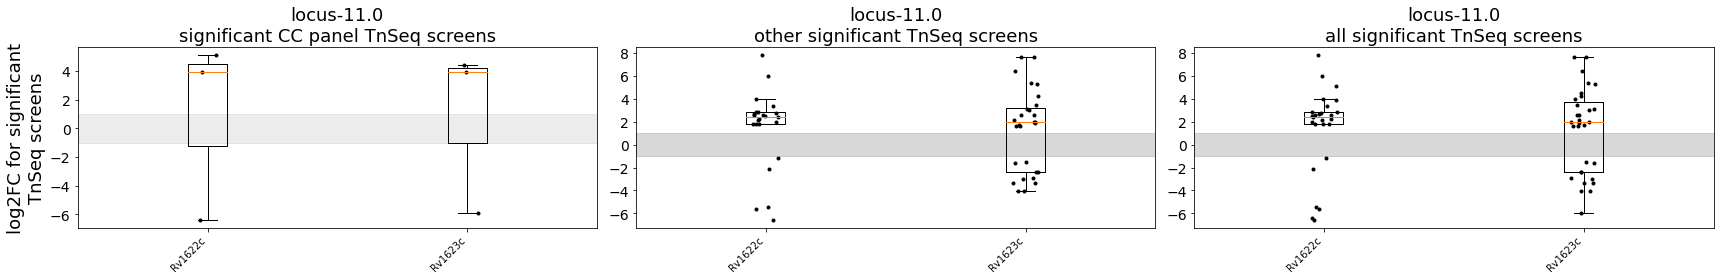

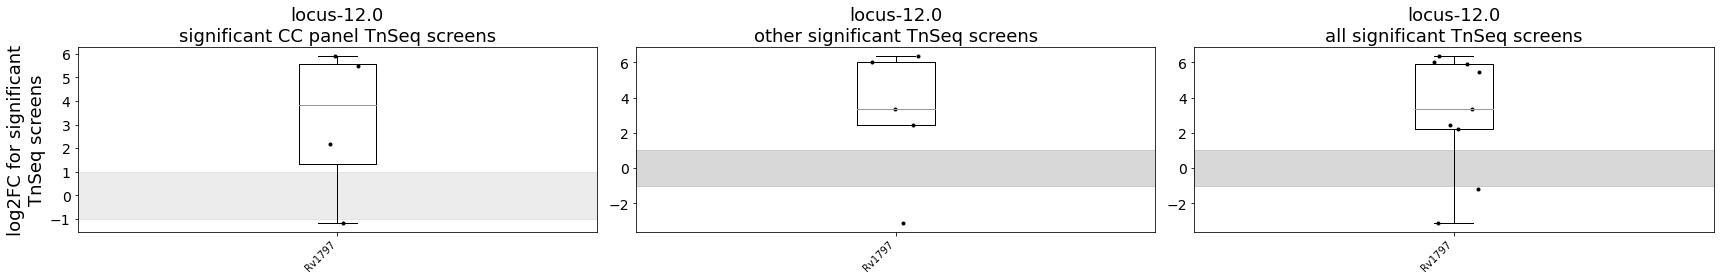

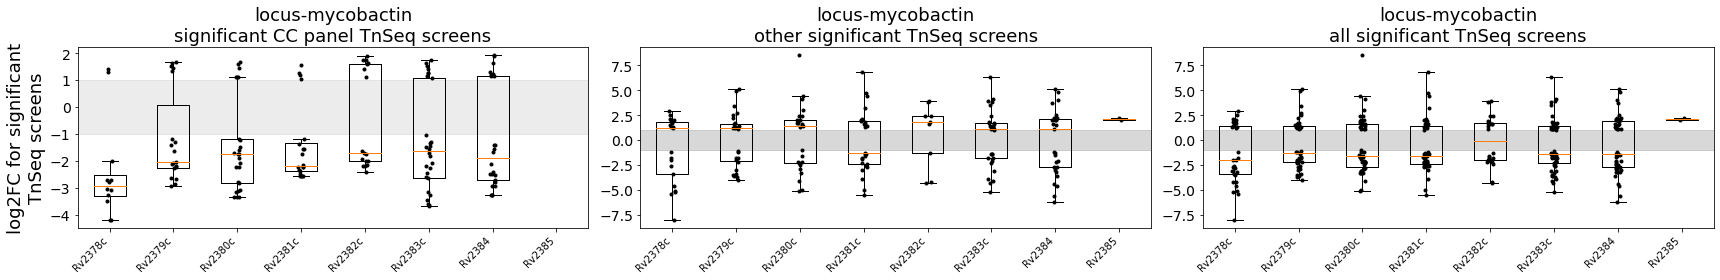

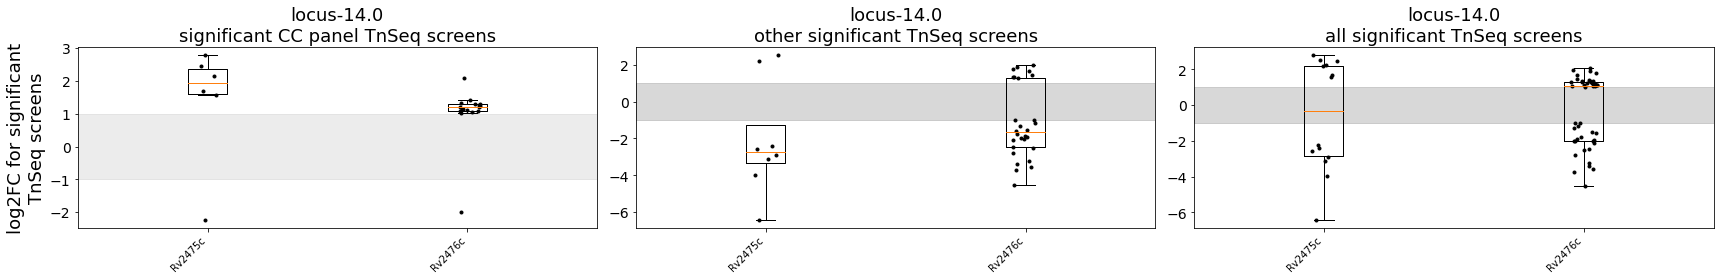

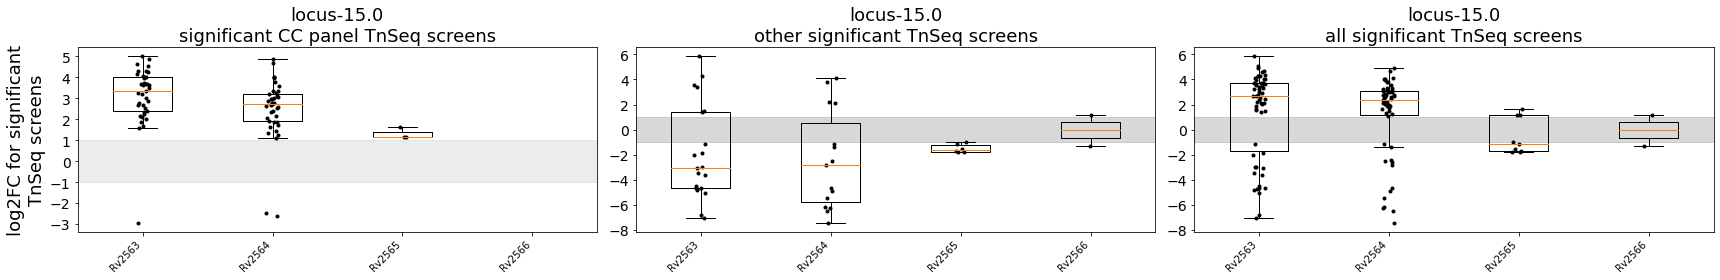

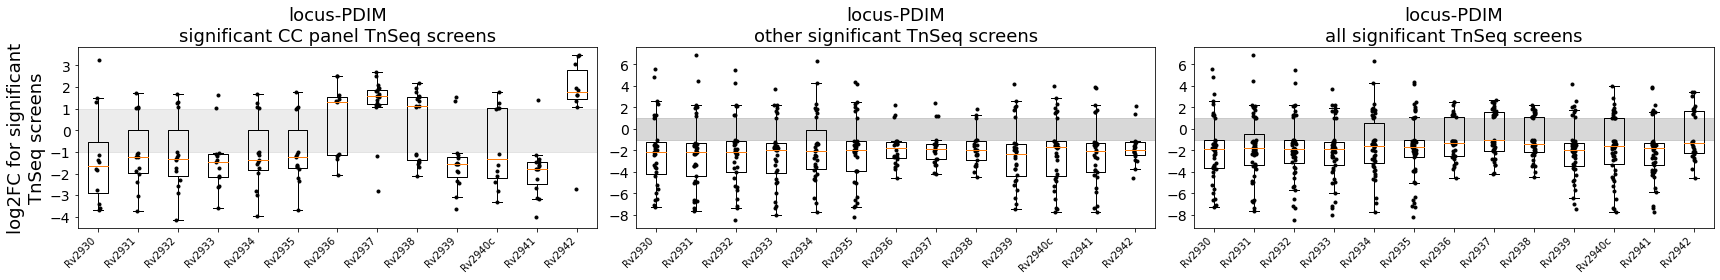

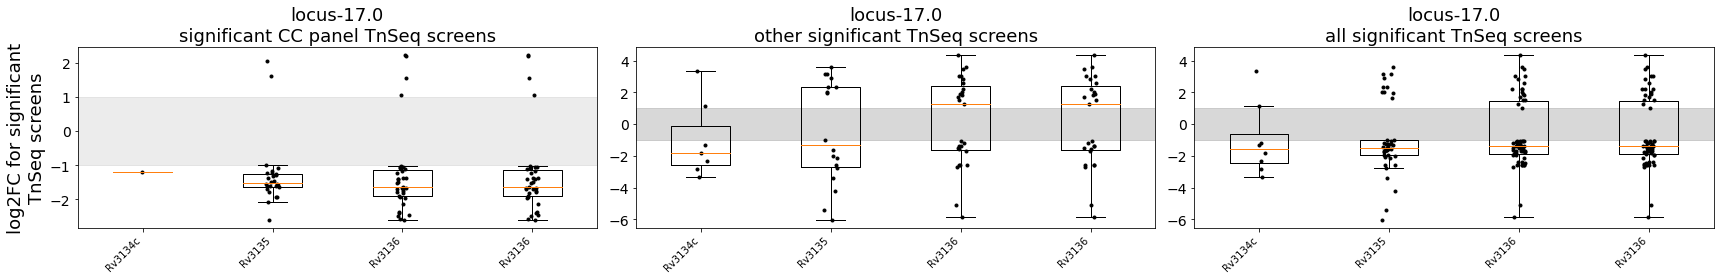

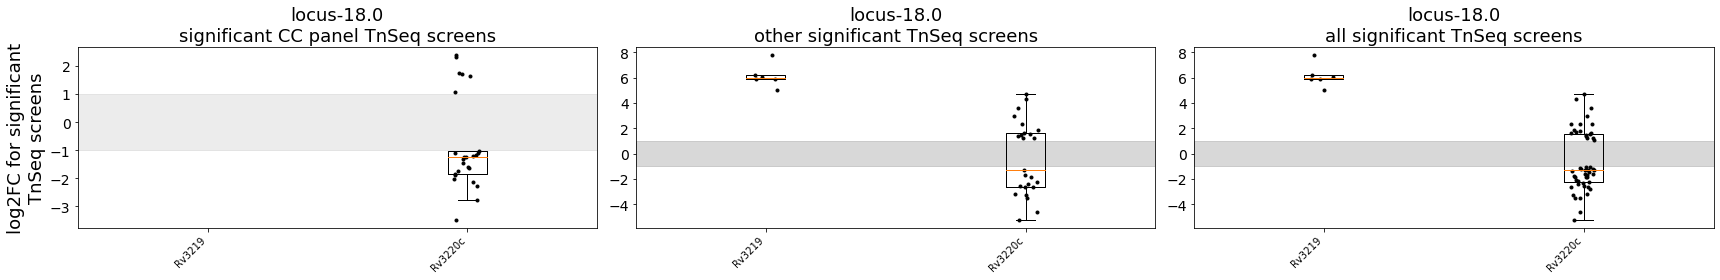

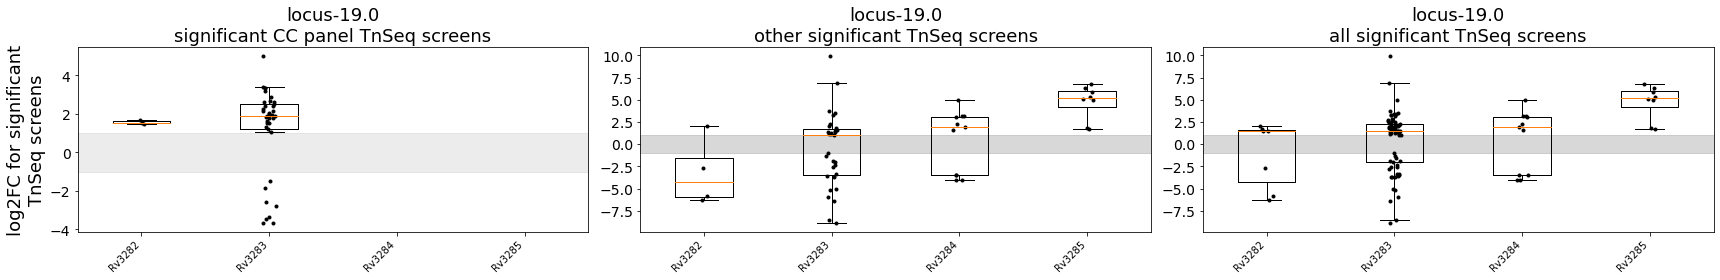

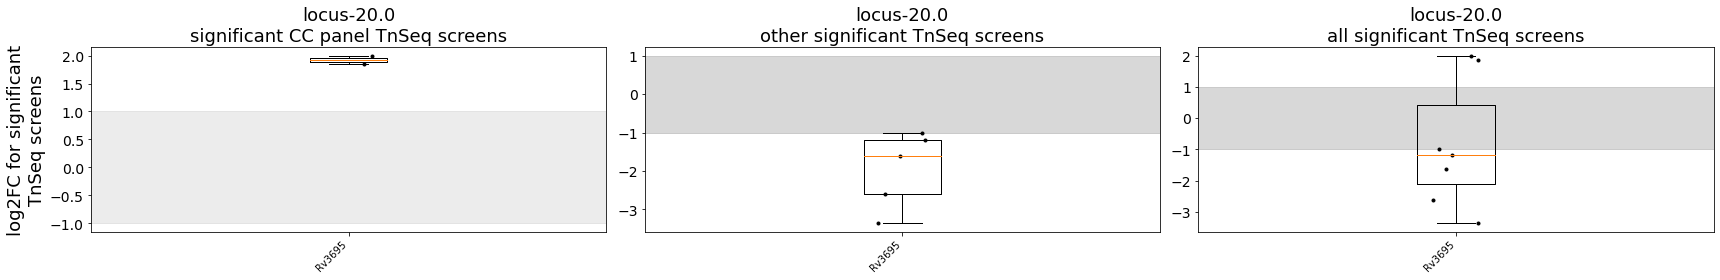

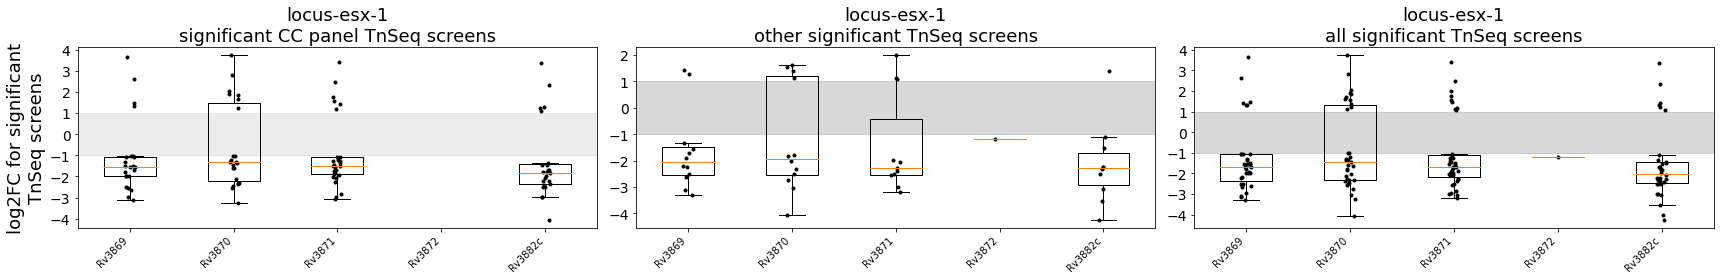

In [189]:
for locus_name in df_loci.locus_name.unique():
    locus_name_str = str(locus_name)
    locus_name_str = 'locus-'+locus_name_str
    list_rv_id = df_loci[df_loci.locus_name == locus_name].Rv_ID.values
    make_loci_boxplots(list_rv_id, df_bin_annot, df_lfc, locus_name_str)

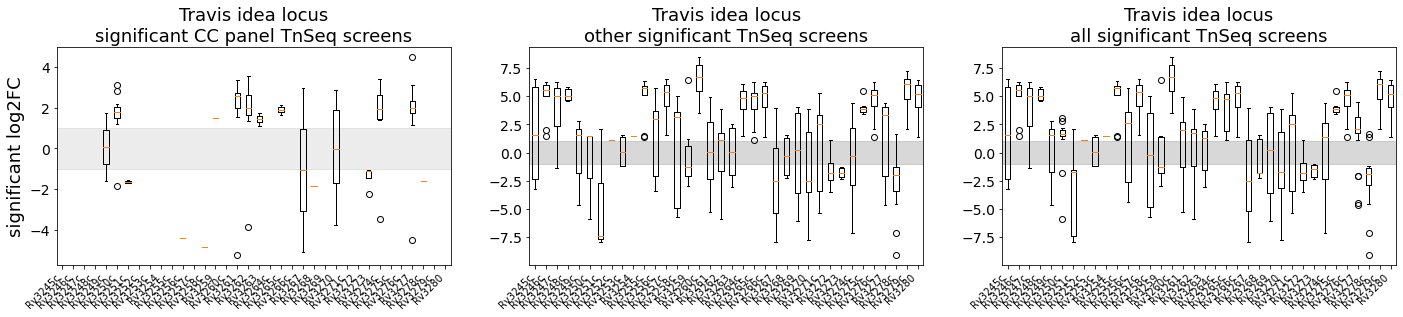

In [207]:
list_test_noc = ['Rv'+str(i) for i in range(3245,3281)]
list_test_c = [rvid+'c' for rvid in list_test]
list_test = list_test_noc+list_test_c
list_rvid_test = df_up_func[ df_up_func.Rv_ID.isin(list_test) ].Rv_ID.tolist()
list_rvid_test.sort()
locus_name = 'Travis idea locus'
make_loci_boxplots(list_rvid_test, df_bin_annot, df_lfc, locus_name)

## Other: 

In [16]:
# df_bin_annot[ (df_bin_annot.Rv_ID.str.contains('Rv292')) |  (df_bin_annot.Rv_ID.str.contains('Rv293')) | (df_bin_annot.Rv_ID.str.contains('Rv294'))][['Rv_ID','gene_name', 'func_tuberculist' ,'sum_CES']]

### Distribution of essentiality counts across genes: 

Let's start with the free stuff:
How many genes are conditionally essential in 10 or more screens? 0 screens?

In [132]:
df_bin[df_bin.sum_CES.values == 0][['Rv_ID', 'sum_CES']].shape

(694, 2)

In [133]:
df_bin[df_bin.sum_CES.values >= 10][['Rv_ID', 'sum_CES']].shape

(674, 2)

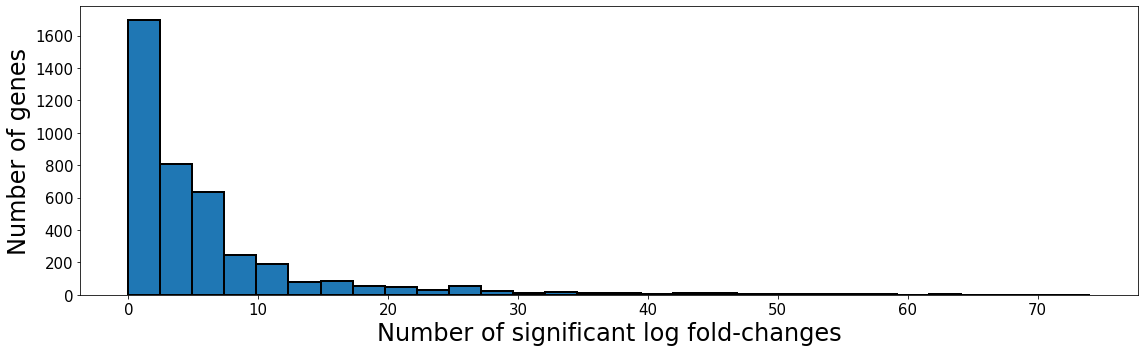

In [134]:
plt.figure(figsize = (16,5))
# hist = plt.hist(df_bin['sum_CES'].values, bins = np.arange(-0.5, 40), edgecolor='black', linewidth=2)
hist = plt.hist(df_bin['sum_CES'].values, edgecolor='black', linewidth=2, bins = 30)

plt.xlabel('Number of significant log fold-changes', fontsize = 24)
plt.ylabel('Number of genes', fontsize = 24)
plt.xticks(fontsize = 15)
yt = plt.yticks(fontsize = 15)
plt.tight_layout()
out_file = os.path.join(dir_figs, 'gene_stats_092821.png')
plt.savefig(out_file, dpi = 300)

Quick attempt at CDF plot:

In [86]:
df_bin[df_bin['sum_CES'] >= 25].shape

(181, 127)

In [38]:
df_bin['sum_CES'].max()

74.0

In [39]:
xrange = np.arange(0, 80)
cdf_list = []
for x in xrange:
    cdf_val = len([data for data in df_bin['sum_CES'].values if data <= x]) / len(df_bin['sum_CES'].values)
    cdf_list.append(cdf_val)

Text(0.5, 0, 'Number of conditionally essential calls')

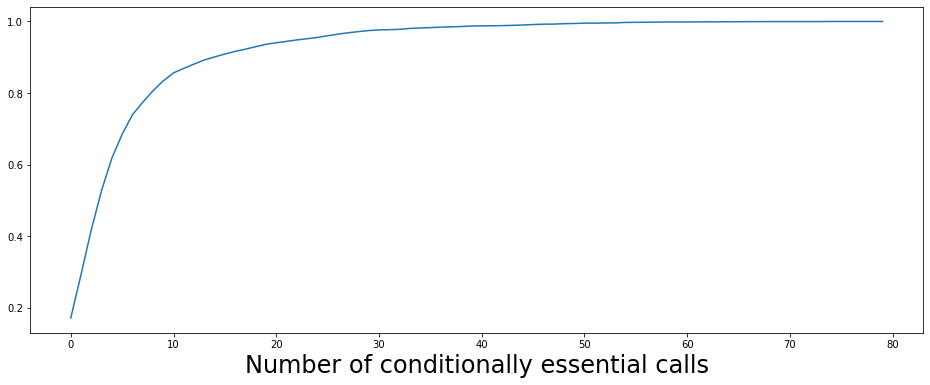

In [40]:
plt.figure(figsize = (16,6))
plt.plot(xrange, cdf_list)
plt.xlabel('Number of conditionally essential calls', fontsize = 24)

# Can we identify the core essentials in the 0-bin?

In [73]:
file_mbio = '../../data/SI_datasets/2017A_DeJesus_Iorger/table_1.xlsx'
df_mbio = pd.read_excel(file_mbio)
df_mbio['Final Call'].unique()

array(['ES', 'NE', 'ESD', 'GD', 'Uncertain', 'GA'], dtype=object)

In [74]:
df_mbio_ES = df_mbio[ (df_mbio['Final Call'].values =='ES') | (df_mbio['Final Call'].values =='GD' )].copy()

df_tn_mbio = df_bin[df_bin.Rv_ID.isin(df_mbio_ES.Rv_ID)][['Rv_ID', 'sum_CES']]
df_tn_mbio.shape

(596, 2)

In [75]:
x_vals = np.array(df_tn_mbio.sum_CES.value_counts().index)
y_vals = np.array(df_tn_mbio.sum_CES.value_counts().values)

How many of the mbio 2017 essentials have zero conditional essentiality calls?

In [81]:
df_tn_mbio[df_tn_mbio.sum_CES.values>0].sort_values(by = 'sum_CES', ascending = False)

,Rv_ID,sum_CES
3393,Rv3277,26.0
2478,Rv2400c,25.0
479,Rv0467,23.0
974,Rv0946c,20.0
2536,Rv2455c,19.0
...,...,...
2538,Rv2457c,1.0
1166,Rv1133c,1.0
1201,Rv1166,1.0
2520,Rv2439c,1.0


In [82]:
rvid = 'Rv3277'
cols = df_bin.columns

[col for col in cols if df_bin[df_bin.Rv_ID == rvid][col].values[0] == 1]

['Rv3717_KO_vs_Rubin_FLUTE_WT',
 'carey_621_vs_carey_rv',
 'carey_631_vs_carey_rv',
 'carey_632_vs_carey_rv',
 'carey_641_vs_carey_rv',
 'carey_662_vs_carey_rv',
 'carey_667_vs_carey_rv',
 'dejesus_Rv1432_day0_vs_dejesus_H37Rv_day0',
 'dejesus_Rv2680_day0_vs_dejesus_H37Rv_day0',
 '129s1.SvImJ_vs_C57BL.6J',
 'C57BL.6J_vs_mbio_H37Rv',
 'CC002.Unc_vs_C57BL.6J',
 'CC004.TauUnc_vs_C57BL.6J',
 'CC006.TauUnc_vs_C57BL.6J',
 'CC009.Unc_vs_C57BL.6J',
 'CC012.GeniUnc_vs_C57BL.6J',
 'CC015.Unc_vs_C57BL.6J',
 'CC018.Unc_vs_C57BL.6J',
 'CC019.TauUnc_vs_C57BL.6J',
 'CC023.GeniUnc_vs_C57BL.6J',
 'CC024.GeniUnc_vs_C57BL.6J',
 'CC039.Unc_vs_C57BL.6J',
 'CC041.TauUnc_vs_C57BL.6J',
 'CC051.TauUnc_vs_C57BL.6J',
 'NOD.ShiLtJ_vs_C57BL.6J',
 'PWK.PhJ_vs_C57BL.6J']

In [83]:
col_temp = 'CC012.GeniUnc_vs_C57BL.6J'
rvid = 'Rv3277'
df_lfc[df_lfc.Rv_ID == rvid][col_temp]

3393    2.3
Name: CC012.GeniUnc_vs_C57BL.6J, dtype: float64

Show these in the histogram: 

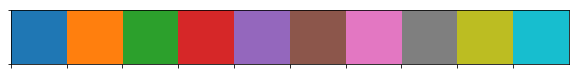

In [17]:
current_palette = sns.color_palette()
sns.palplot(current_palette)

In [19]:
num_disp = df_bin[df_bin.sum_CES.values == 0].shape[0]

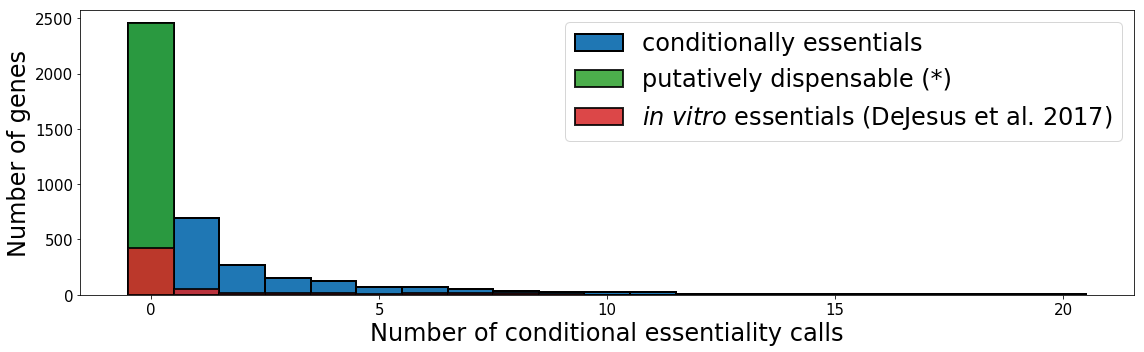

In [26]:
num_ES = df_mbio_ES.shape[0]

plt.figure(figsize = (16,5))

hist = plt.hist(df_bin['sum_CES'].values, bins = np.arange(-0.5, 21), color=current_palette[0], edgecolor='black', linewidth=2)
plt.bar(0, num_disp, color = current_palette[2], width=1, edgecolor='k', linewidth=2, alpha=0.85)
plt.bar(x_vals, y_vals, color = current_palette[3], width=1, edgecolor='k', linewidth=2, alpha=0.85)

# sns.distplot(df_tn['sum_all'].values, bins = np.arange(-0.5, 21))
plt.xlabel('Number of conditional essentiality calls', fontsize = 24)
plt.ylabel('Number of genes', fontsize = 24)
plt.xticks(fontsize = 15)
yt = plt.yticks(fontsize = 15)
plt.legend(['conditionally essentials', 'putatively dispensable (*)','$\it{in}$ $\it{vitro}$ essentials (DeJesus et al. 2017)'], fontsize = 24)
plt.tight_layout()

# out_file = os.path.join(dir_figs, 'gene_stats.png')
# plt.savefig(out_file, dpi = 300)

##### New version (02/01/2021)

In [18]:
# for the new version of the plot
df_mbio_ES_ONLY = df_mbio[ (df_mbio['Final Call'].values =='ES')].copy()
df_mbio_GD = df_mbio[ (df_mbio['Final Call'].values =='GD' )].copy()
df_mbio_GA = df_mbio[ (df_mbio['Final Call'].values =='GA' )].copy()
df_mbio_NE = df_mbio[ (df_mbio['Final Call'].values =='NE' )].copy()

# 
df_tn_mbio_ES_ONLY = df_bin[df_bin.Rv_ID.isin(df_mbio_ES_ONLY.Rv_ID)][['Rv_ID', 'sum_CES']]
df_tn_mbio_GD = df_bin[df_bin.Rv_ID.isin(df_mbio_GD.Rv_ID)][['Rv_ID', 'sum_CES']]
df_tn_mbio_GA = df_bin[df_bin.Rv_ID.isin(df_mbio_GA.Rv_ID)][['Rv_ID', 'sum_CES']]
df_tn_mbio_NE = df_bin[df_bin.Rv_ID.isin(df_mbio_NE.Rv_ID)][['Rv_ID', 'sum_CES']]

# 
xbins = np.arange(-0.5, 25.5, 1)
yx_vals_ES_ONLY = np.histogram(df_tn_mbio_ES_ONLY.sum_CES.values, bins = xbins)
yvals_ES_ONLY = yx_vals_ES_ONLY[0]

yx_vals_GD = np.histogram(df_tn_mbio_GD.sum_CES.values, bins = np.arange(-0.5, 25.5, 1))
yvals_GD = yx_vals_GD[0]

yx_vals_GA = np.histogram(df_tn_mbio_GA.sum_CES.values, bins = np.arange(-0.5, 25.5, 1))
yvals_GA = yx_vals_GA[0]

yx_vals_NE = np.histogram(df_tn_mbio_NE.sum_CES.values, bins = np.arange(-0.5, 25.5, 1))
yvals_NE = yx_vals_NE[0]

In [25]:
df_tn_mbio_ES_ONLY[df_tn_mbio_ES_ONLY.sum_CES.values == 0].shape[0] + df_tn_mbio_GD[df_tn_mbio_GD.sum_CES.values == 0].shape[0]

425

(135, 2)

In [115]:
xvals_ALL = np.arange(0, 25)

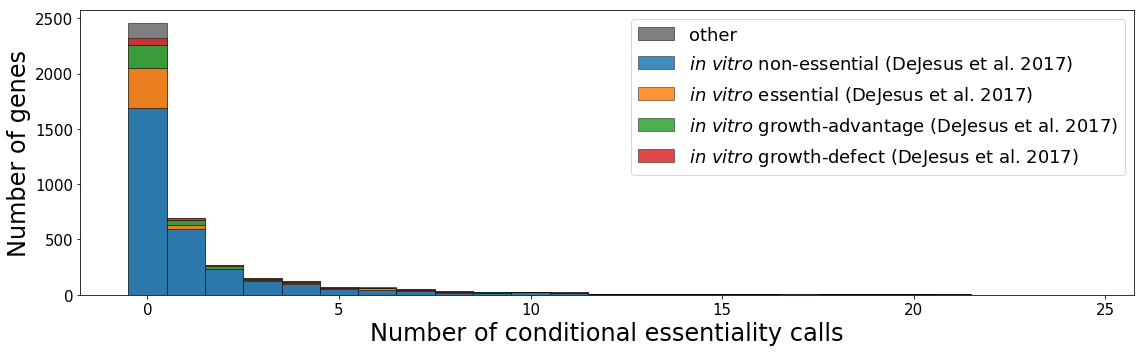

In [144]:
plt.figure(figsize = (16,5))
lw_param = 0.5

hist = plt.hist(df_bin['sum_CES'].values, bins = np.arange(-0.5, 21), color=current_palette[-3], edgecolor='black', linewidth=lw_param)

plt.bar(xvals_ALL, yvals_NE, color = current_palette[0], width=1, edgecolor='k', linewidth=lw_param, alpha=0.85)

arr_bottom = yvals_NE
plt.bar(xvals_ALL, yvals_ES_ONLY, bottom=arr_bottom , color = current_palette[1], width=1, edgecolor='k', linewidth=lw_param, alpha=0.85)

arr_bottom = arr_bottom + yvals_ES_ONLY
plt.bar(xvals_ALL, yvals_GA, bottom=arr_bottom , color = current_palette[2], width=1, edgecolor='k', linewidth=lw_param, alpha=0.85)

arr_bottom = arr_bottom + yvals_GA
plt.bar(xvals_ALL, yvals_GD, bottom=arr_bottom , color = current_palette[3], width=1, edgecolor='k', linewidth=lw_param, alpha=0.85)

plt.legend(['other', '$\it{in}$ $\it{vitro}$ non-essential (DeJesus et al. 2017)', '$\it{in}$ $\it{vitro}$ essential (DeJesus et al. 2017)', 
           '$\it{in}$ $\it{vitro}$ growth-advantage (DeJesus et al. 2017)', '$\it{in}$ $\it{vitro}$ growth-defect (DeJesus et al. 2017)'], fontsize = 18)

plt.xlabel('Number of conditional essentiality calls', fontsize = 24)
plt.ylabel('Number of genes', fontsize = 24)
plt.xticks(fontsize = 15)
yt = plt.yticks(fontsize = 15)

plt.tight_layout()

out_file = os.path.join(dir_figs, 'gene_stats_v2.png')
plt.savefig(out_file, dpi = 300)

In [145]:
file_out = '../../data/annotations/data_for_Michael_1.csv'
df_bin.to_csv(file_out, index = False)

file_out = '../../data/annotations/data_for_Michael_2.csv'
df_mbio.to_csv(file_out, index = False)

Which have 1 or more conditional essentiality calls?

In [71]:
rvid_ES_CES = df_tn_mbio[df_tn_mbio.sum_all>0].Rv_ID.values

In [67]:
def essentiality_calls(df, gene_id):
# Return the columns in which a given gene is called essential:
    cols = df.columns[1:]
    col_list = []
    for col in cols:
        if df[df['Rv_ID']==gene_id][col].values[0] == 1:
            col_list.append(col)
            
    return col_list

In [73]:
CES_list = []
for gene_id in rvid_ES_CES:
    CES_list.append(essentiality_calls(df_tn, gene_id))
df_ES_CES = pd.DataFrame()
df_ES_CES['Rv_ID'] = rvid_ES_CES
df_ES_CES['CES_calls'] = ['; '.join(CES[:-1]) for CES in CES_list]

In [75]:
file_out = '../../dep/data/ES_with_CES_calls.csv'
df_ES_CES.to_csv(file_out, index = False)

In [77]:
df_ES_CES[df_ES_CES.CES_calls.str.contains('carey')].shape

(105, 2)

### Which genes are the tail of the distribution?

In [102]:
df_tn_top_wName = df_tn_top.merge(df_mbio, how = 'left', on = 'Rv_ID')[['Rv_ID', 'sum_all', 'Name']]
file_out = '../../data/top_genes_CES_calls.xlsx'
df_tn_top_wName.to_excel(file_out, index= False)

### Cumulative distribution:

In [50]:
myrange = np.arange(df_tn['sum_all'].max())
cdf = np.zeros(len(myrange))
for n in myrange:
    cdf[int(n)] = df_tn[df_tn.sum_all<=n].shape[0] / df_tn.shape[0]

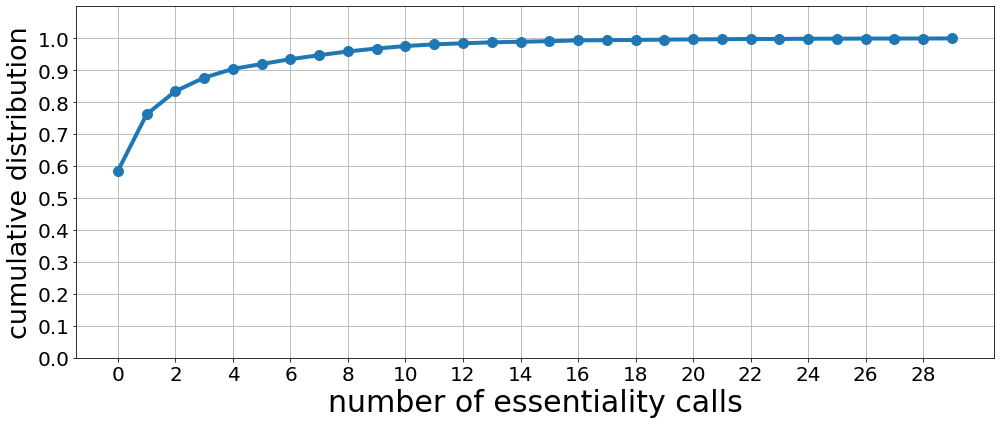

In [51]:
plt.figure(figsize = (14,6))
plt.plot(myrange, cdf, '-o', lw = 4, ms = 10)
xt = plt.xticks( np.arange(0, df_tn['sum_all'].max(), 2), fontsize = 20)
plt.ylim(0, 1.1)
yt = plt.yticks(np.arange(0, 1.1, 0.1), fontsize = 20)
plt.xlabel('number of essentiality calls', fontsize = 30)
plt.ylabel('cumulative distribution', fontsize = 27)
plt.grid(True, xdata = myrange)
plt.tight_layout()
